In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2023-03-13 16:24:24.723306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 16:24:24.928586: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-13 16:24:25.781462: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/avaz/nuws/install/lib:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/li

# Specify each path

In [2]:
# path prefix needs to be modified for changing, training, and saving new models
path_prefix = '/home/avaz/courses/w23/winter-project/hgr_go1_ws/src/go1_hgr_ros2/ros2_hgr/'
dataset = path_prefix+'model/keypoint_classifier/keypoint.csv'
model_save_path = path_prefix+'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = path_prefix+'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 8

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

2023-03-13 16:24:30.628484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-13 16:24:30.628531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (husky): /proc/driver/nvidia/version does not exist
2023-03-13 16:24:30.629234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
48/49 [============================>.] - ETA: 0s - loss: 2.0402 - accuracy: 0.1919
Epoch 1: saving model to /home/avaz/courses/w23/winter-project/hgr_go1_ws/src/go1_hgr_ros2/ros2_hgr/model/keypoint_classifier/keypoint_classifier.hdf5
49/49 [==============================] - 1s 8ms/step - loss: 2.0384 - accuracy: 0.1928 - val_loss: 1.9224 - val_accuracy: 0.2704
Epoch 2/1000
43/49 [=========================>....] - ETA: 0s - loss: 1.8933 - accuracy: 0.2832
Epoch 2: saving model to /home/avaz/courses/w23/winter-project/hgr_go1_ws/src/go1_hgr_ros2/ros2_hgr/model/keypoint_classifier/keypoint_classifier.hdf5
49/49 [==============================] - 0s 4ms/step - loss: 1.8883 - accuracy: 0.2815 - val_loss: 1.7536 - val_accuracy: 0.3933
Epoch 3/1000
30/49 [=================>............] - ETA: 0s - loss: 1.7852 - accuracy: 0.3182
Epoch 3: saving model to /home/avaz/courses/w23/winter-project/hgr_go1_ws/src/go1_hgr_ros2/ros2_hgr/model/keypoint_classifier/keypoint_classifier.hdf5
4

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

17/17 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.9248


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 69ms/step
[6.58838451e-02 1.03943616e-01 1.15076927e-02 1.10242877e-03
 4.41209599e-03 9.45032389e-06 8.13136339e-01 4.47879665e-06]
6


# Confusion matrix

65/65 [==============================] - 0s 972us/step


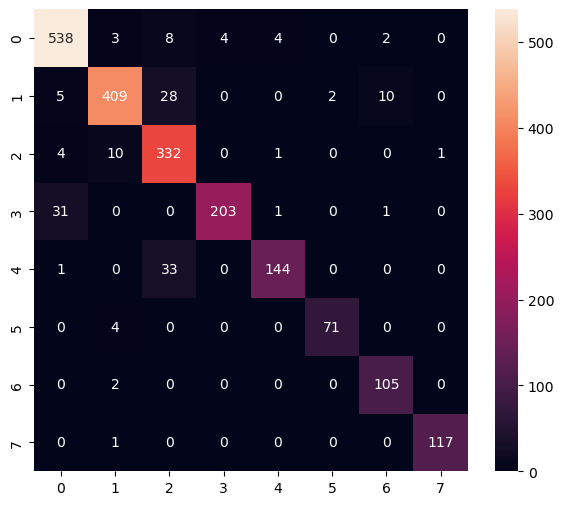

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       559
           1       0.95      0.90      0.93       454
           2       0.83      0.95      0.89       348
           3       0.98      0.86      0.92       236
           4       0.96      0.81      0.88       178
           5       0.97      0.95      0.96        75
           6       0.89      0.98      0.93       107
           7       0.99      0.99      0.99       118

    accuracy                           0.92      2075
   macro avg       0.94      0.93      0.93      2075
weighted avg       0.93      0.92      0.92      2075



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp05_9ia9_/assets


INFO:tensorflow:Assets written to: /tmp/tmp05_9ia9_/assets
2023-03-13 16:25:02.652472: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-03-13 16:25:02.652501: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-03-13 16:25:02.653286: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp05_9ia9_
2023-03-13 16:25:02.654498: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-03-13 16:25:02.654545: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp05_9ia9_
2023-03-13 16:25:02.659408: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-13 16:25:02.660444: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-03-13 16:25:02.699355: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

6720

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 214 µs, sys: 15 µs, total: 229 µs
Wall time: 221 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.5883867e-02 1.0394356e-01 1.1507673e-02 1.1024291e-03 4.4120909e-03
 9.4503166e-06 8.1313652e-01 4.4787853e-06]
6
